In [1]:
import matplotlib.pyplot as plt

In [2]:
from Hackaton.python.read_pics import get_pics_from_file

In [3]:
# pics_name = ["pics_0", "pics_1", "pics_2", "pics_3", "pics_4", "pics_5", "pics_6", "pics_7", "pics_8", "pics_9", "pics_NOKEY"]
pics_name = ["pics_0", "pics_1"]

In [4]:
# import all pics
pics = dict()
info = dict()
listpics = []
for pic in pics_name:
    (curr_pic, info[pic]) = get_pics_from_file(f'Hackaton/data/{pic}.bin')
    pics[pic] = curr_pic
    listpics.append(pic)

Ouverture du fichier de pics Hackaton/data/pics_0.bin
Ouverture du fichier de pics Hackaton/data/pics_1.bin


In [5]:
# List of name (X)
len(["pics_0", "pics_1", "pics_2", "pics_3"])

4

In [6]:
# list of name (Y)
print("toto")

toto


KeyError: KeyError: 'nb_pics'

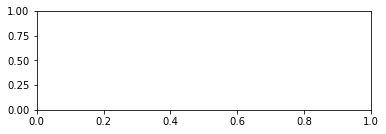

In [7]:
plt.figure(1)
plt.subplot(211)
plt.plot(range(1,info["nb_pics"]+1), pics_nokey[0], 'ko', color='green')
plt.plot(range(1,info["nb_pics"]+1), pics_pad0[0], 'ko', color='red')
plt.plot(range(1,info["nb_pics"]+1), pics_pad1[0], 'ko', color='orange')
plt.xlabel('numéro de pic')
plt.ylabel('valeur du pic')
plt.title('no key')
plt.ylim(0, 1.5)
plt.grid(b=True, which='both')

In [26]:

pics_nokey, info

([array([0.7244873 , 0.34118652, 0.30456543, 0.84960938, 0.98022461,
         0.66711426, 0.5682373 , 0.62133789, 0.86303711, 0.11535645,
         0.58532715, 0.44616699, 0.30029297, 0.71289062, 0.45227051,
         0.5279541 , 0.15563965]),
  array([0.5090332 , 0.33569336, 0.34423828, 0.27160645, 0.31921387,
         0.24780273, 0.26489258, 0.68664551, 0.92651367, 0.234375  ,
         0.64086914, 0.27954102, 0.625     , 0.69274902, 0.62072754,
         0.37414551, 1.03515625]),
  array([0.40100098, 0.18981934, 0.27648926, 0.17150879, 0.14099121,
         0.2154541 , 0.13549805, 0.15686035, 0.23254395, 0.28076172,
         0.23742676, 0.19958496, 0.11657715, 0.31066895, 0.24902344,
         0.24963379, 0.22583008]),
  array([0.63293457, 0.37597656, 0.36987305, 0.91003418, 0.69885254,
         0.41992188, 0.58654785, 0.84960938, 0.72753906, 0.3527832 ,
         0.64758301, 0.72998047, 0.71044922, 0.88256836, 0.99365234,
         0.92834473, 0.43945312]),
  array([0.63781738, 0.38635254,

In [38]:
# Pre-processing
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition


X_size = 17     # Number of features (Pics after PCA)
y_size = 42     # Number of keys

X_train = None
y_train = None

X_test = None
y_test = None

# Normalize
x = Normalizer().fit_transform(x)

# Standardize
x = StandardScaler().fit_transform(x)

# PCA
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

In [0]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

K = 5

# Create and fit model
neigh = KNeighborsClassifier(n_neighbors=K)
neigh.fit(X, y)

# Test
print(neigh.predict(pics[0]))
print(neigh.predict_proba(pics[0]))

In [0]:
# NN
import tensorflow as tf

# Ceate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(X_size, activation='relu'),
    tf.keras.layers.Dense(y_size)
])

# Build model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Debug
model.summary()

# Train
batch_size = 128
epochs = 15

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Test
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])